<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/ConvLSTM_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install imageio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv3DTranspose, ConvLSTM2D, BatchNormalization, LayerNormalization, TimeDistributed, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

import matplotlib.pyplot as plt
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow


tf.keras.backend.set_floatx('float32')

TensorFlow 2.x selected.


In [0]:
class Config:
    def __init__(self, data_dir):
        self.DATASET_PATH = join(data_dir,"UCSDped1/Train/")
        self.TEST_DIR = join(data_dir,"UCSDped1/Test/")
        self.BATCH_SIZE = 4
        self.EPOCHS = 5
        self.GEN_MODEL_PATH = join(data_dir,"model_gen_ConvLSTM_GAN.hdf5")
        self.DIS_MODEL_PATH = join(data_dir,"model_dis_ConvLSTM_GAN.hdf5")
        self.GAN_MODEL_PATH = join(data_dir,"model_combined_ConvLSTM_GAN.hdf5")
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1

conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/") 
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass

In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 32 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):
    """
    seq_size :int 
        The sequence size of individual clip
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 4):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    return clips


def get_single_test(single_test_path, sz):
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def evaluate(test_case_dir, model, sz, gen_only):

    test = get_single_test(join(conf.TEST_DIR,test_case_dir), sz)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sr = reconstructed_sequences
    if gen_only == 1:

        for i in range(0, sz):
            cv2_imshow(np.reshape(reconstructed_sequences[i][0],(256, 256))*256)
            cv2.waitKey()

        #reconstruction_shape = (sz,10, 256, 256, 1)
        sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
        sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
        sr = 1.0 - sa
    #print(sr.shape())

    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [7]:

def get_generator(reload_model=True):
    if reload_model == True and os.path.isfile(conf.GEN_MODEL_PATH):
        model=load_model(conf.GEN_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
        return model, True
    print("Loading generator model")
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=(4,4), padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))   
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=(2,2), padding="same")))
    seq.add(LayerNormalization())

    # # # # #
    seq.add(ConvLSTM2D(64,(3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #

    seq.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=(2,2), padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(64, (11, 11), strides=(4,4), padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    optimizer = tf.keras.optimizers.RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
    seq.compile(optimizer=optimizer, loss='binary_crossentropy')
    seq.summary(line_length=150)
    return seq, False

def get_discriminator(reload_model = True):

    if reload_model == True and os.path.isfile(conf.DIS_MODEL_PATH):
        model=load_model(conf.DIS_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
        return model, True
    model = Sequential()
    ## convolutional layers
    model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', data_format="channels_last", padding="same", batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    model.add(BatchNormalization())
    model.add(Flatten())

    ## MLP architecture with dense layers : 512 -> 128->1
    ## add dropouts to avoid overfitting / perform regularization
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.4))    
    model.add(Dense(units=1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
    #model.compile(optimizer=optimizer, loss='binary_crossentropy')
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    model.summary(line_length=150)
    return model, False





#https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f   
#https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/
#https://arxiv.org/pdf/1802.09088.pdf
get_generator(False)
get_discriminator(False)

Loading generator model
Model: "sequential"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
time_distributed (TimeDistributed)                                 (None, 10, 64, 64, 64)                                      7808                   
______________________________________________________________________________________________________________________________________________________
layer_normalization (LayerNormalization)                           (None, 10, 64, 64, 64)                                      128                    
______________________________________________________________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)              

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f34db475668>,
 False)

In [0]:


def train(generator, discriminator):
    discriminator.trainable = False
    optimizer = tf.keras.optimizers.RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
    gan_input = Input(shape=(conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    fake_image = generator(gan_input)
    
    gan_output = discriminator(fake_image)
    
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    train_dataset = tf.data.Dataset.from_tensor_slices(np.array(get_clips_list(conf.dim1))).batch(conf.BATCH_SIZE)
    for epoch in range(conf.EPOCHS):
        for batch in train_dataset:
            noise = batch + np.random.normal(0, 1, size=(conf.BATCH_SIZE, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
            fake_x = generator.predict(noise)
    
            real_x = batch
            
            x = np.concatenate((real_x, fake_x))
    
            disc_y = np.zeros(2*conf.BATCH_SIZE)
            disc_y[:conf.BATCH_SIZE] = 0.9
    
            d_loss = discriminator.train_on_batch(x, disc_y)
    
            y_gen = np.ones(conf.BATCH_SIZE)
            g_loss = gan.train_on_batch(noise, y_gen)
        gan.reset_states()
        print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    
    generator.save(conf.GEN_MODEL_PATH,save_format='h5')
    discriminator.save(conf.DIS_MODEL_PATH,save_format='h5')
    gan.save(conf.GAN_MODEL_PATH, save_format='h5')
    return gan

Test case loaded


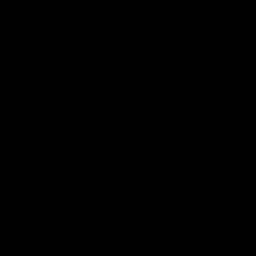

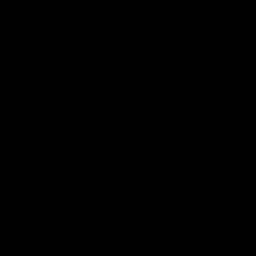

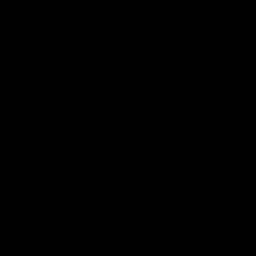

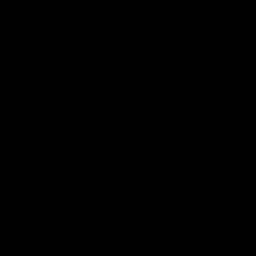

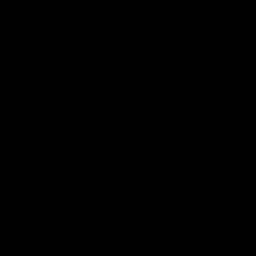

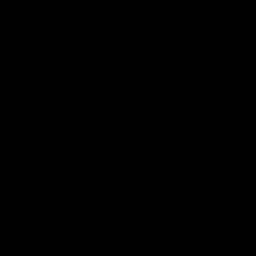

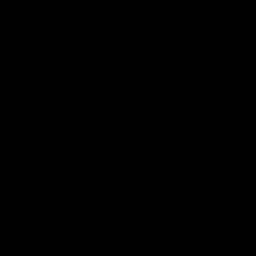

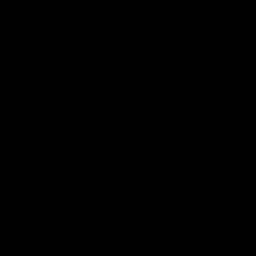

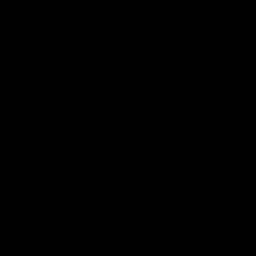

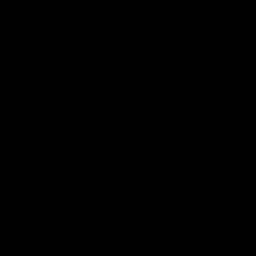

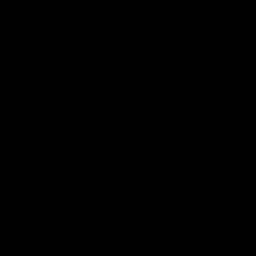

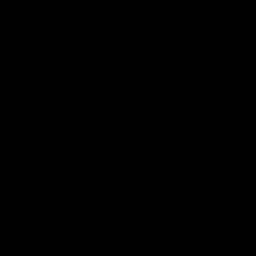

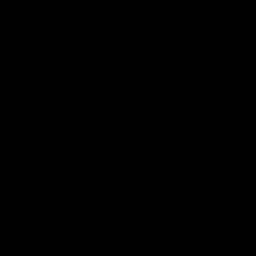

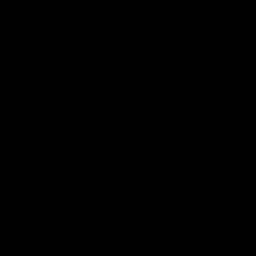

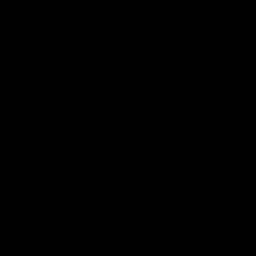

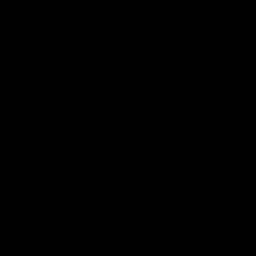

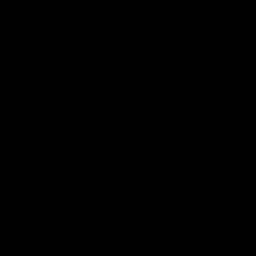

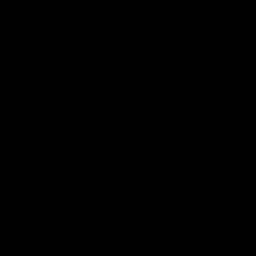

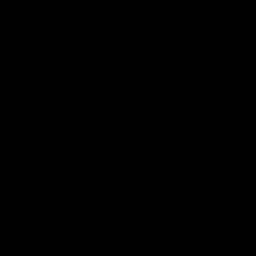

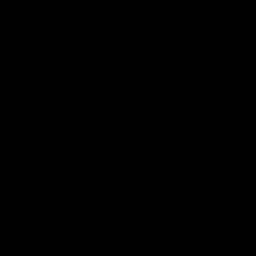

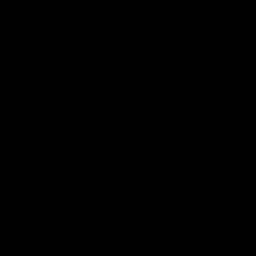

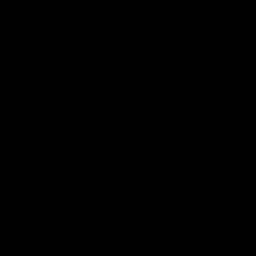

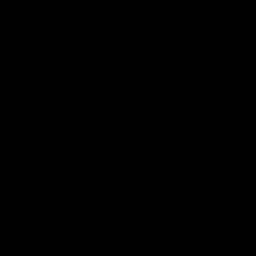

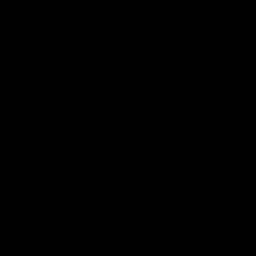

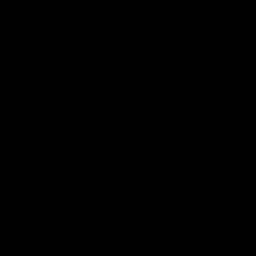

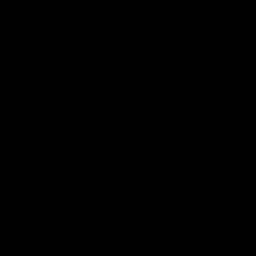

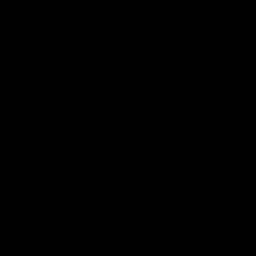

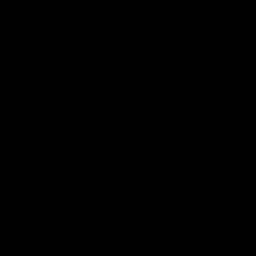

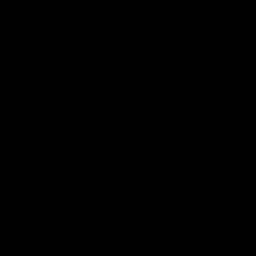

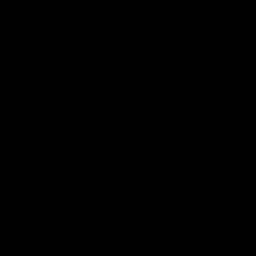

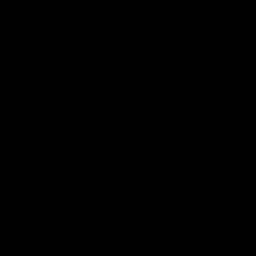

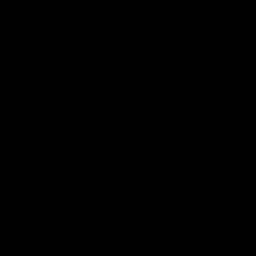

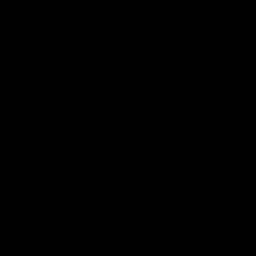

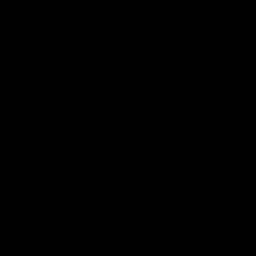

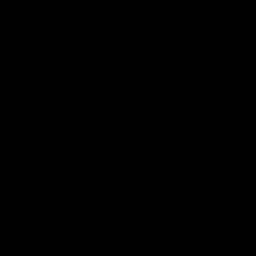

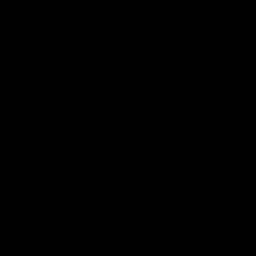

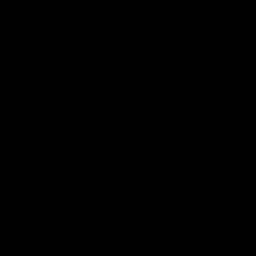

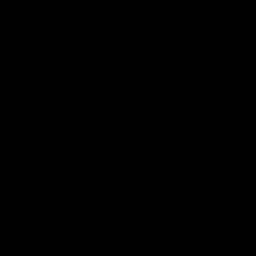

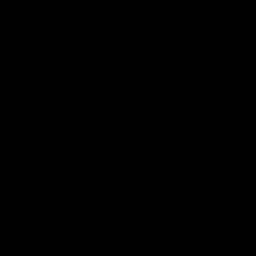

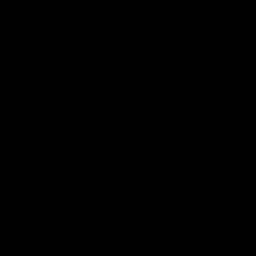

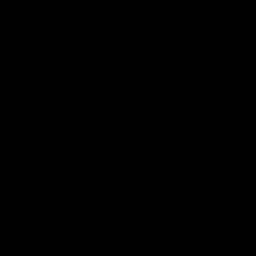

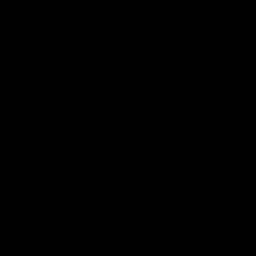

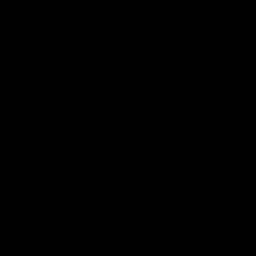

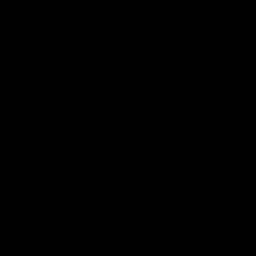

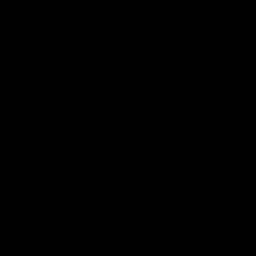

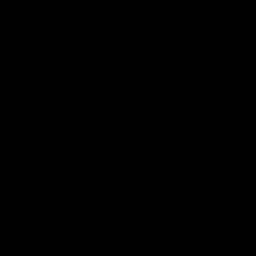

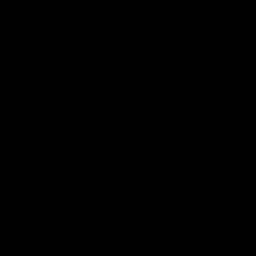

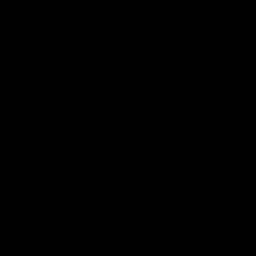

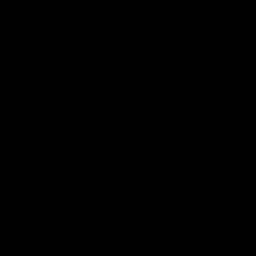

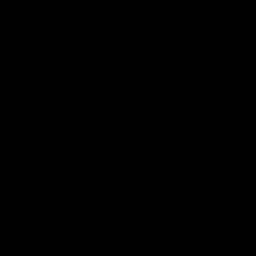

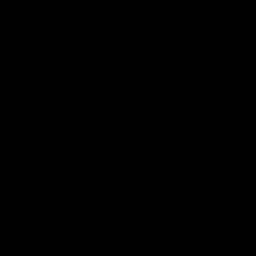

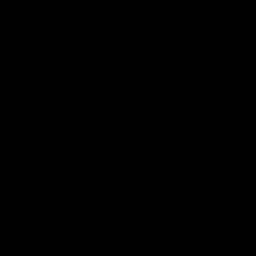

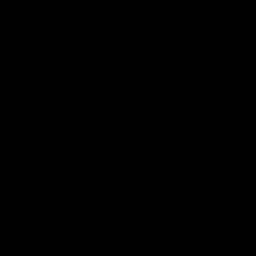

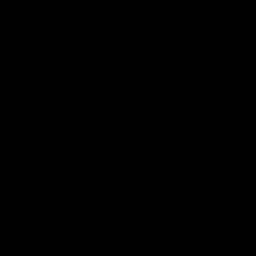

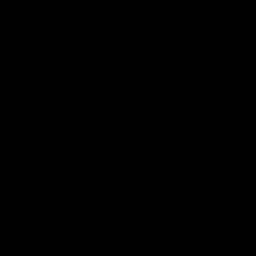

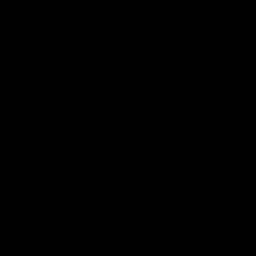

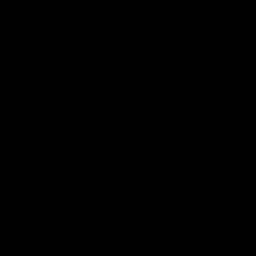

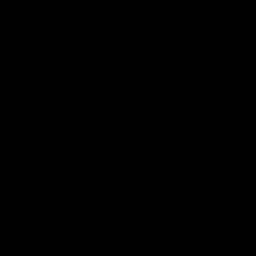

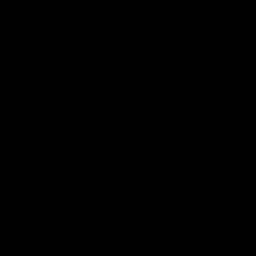

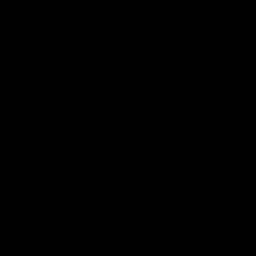

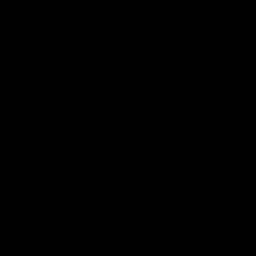

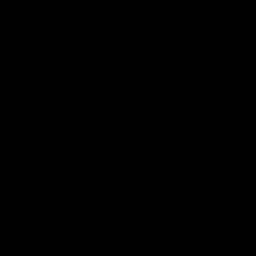

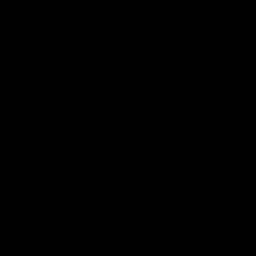

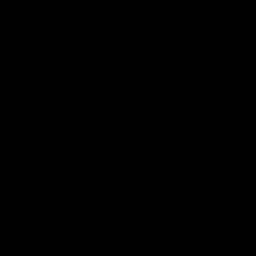

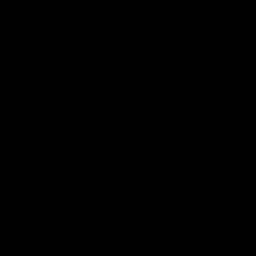

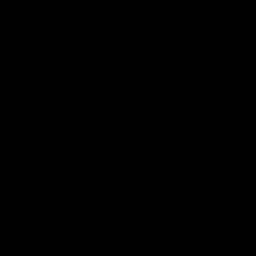

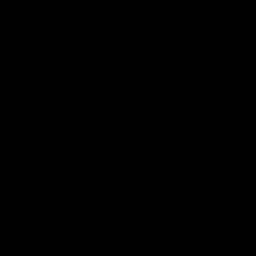

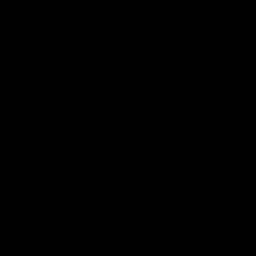

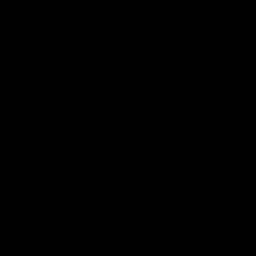

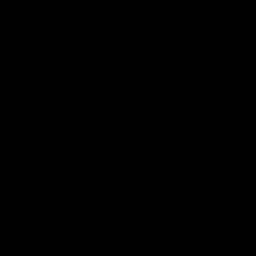

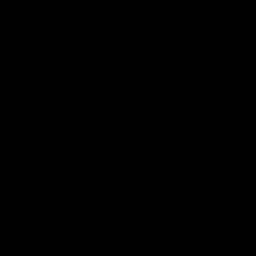

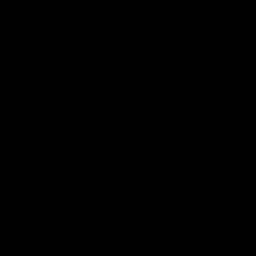

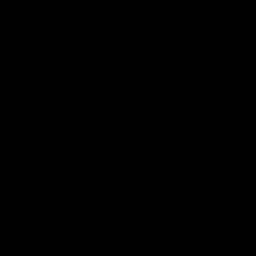

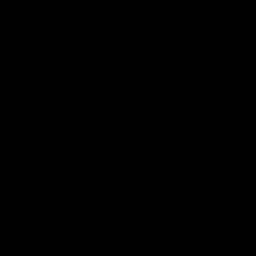

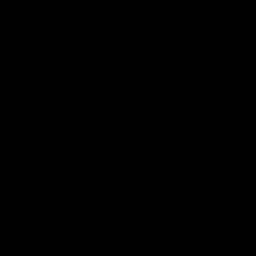

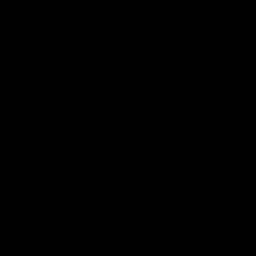

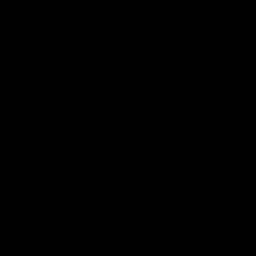

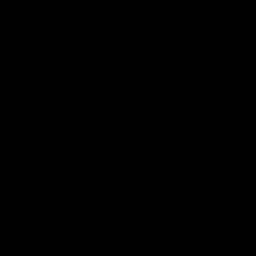

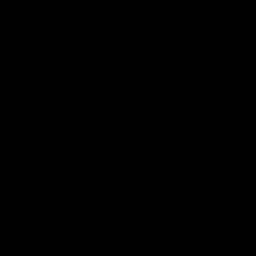

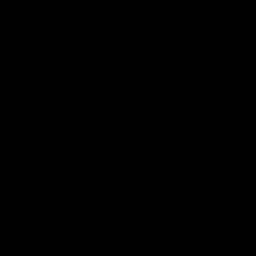

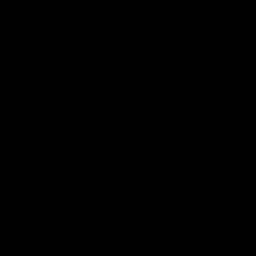

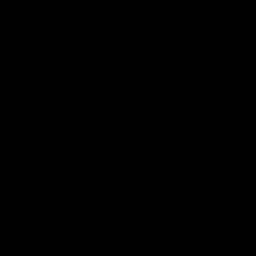

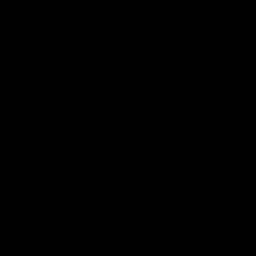

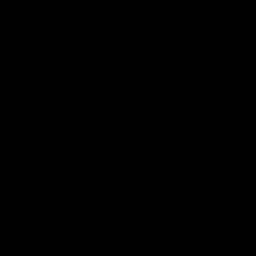

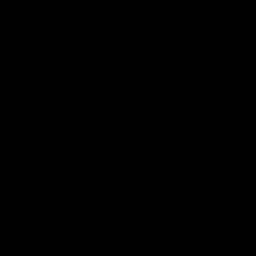

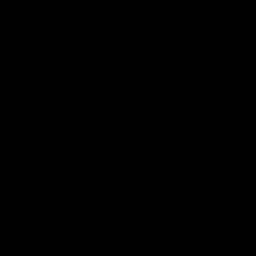

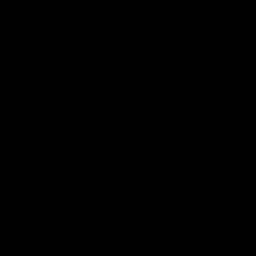

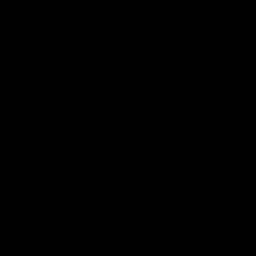

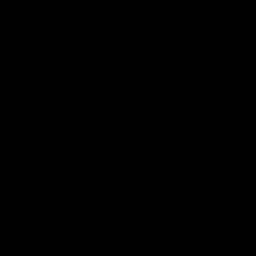

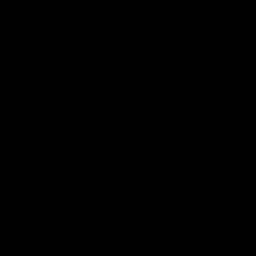

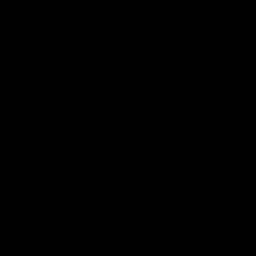

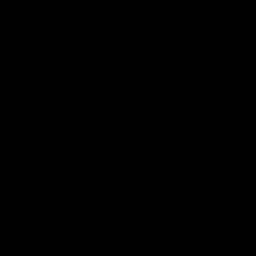

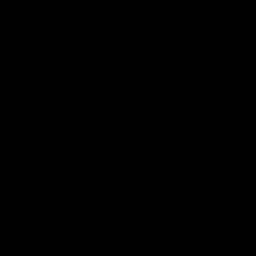

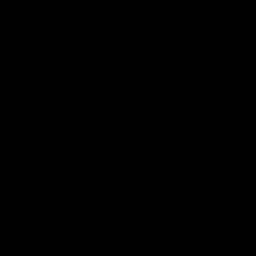

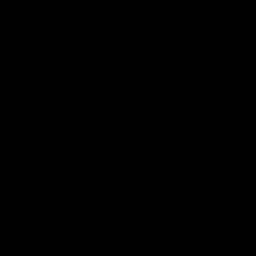

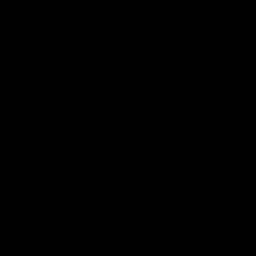

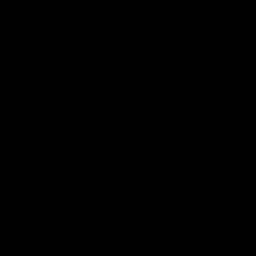

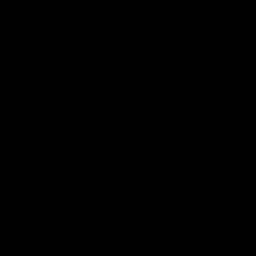

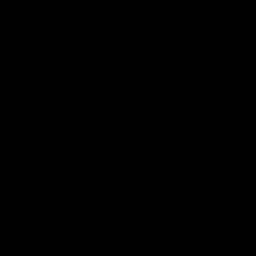

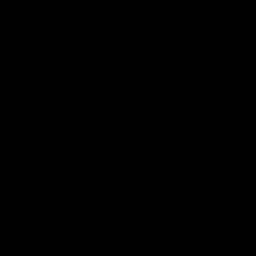

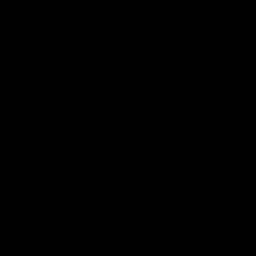

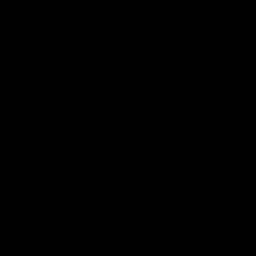

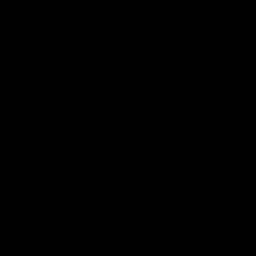

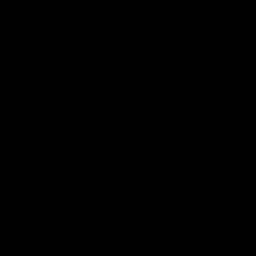

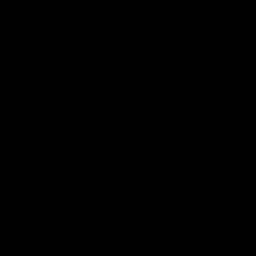

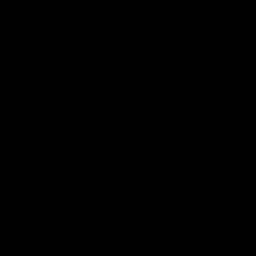

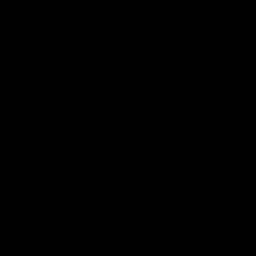

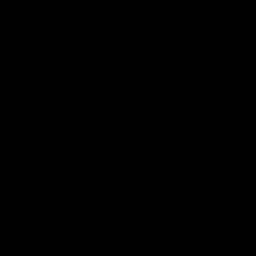

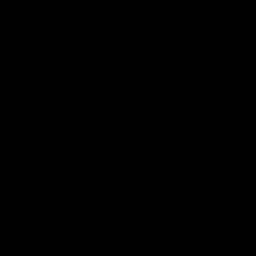

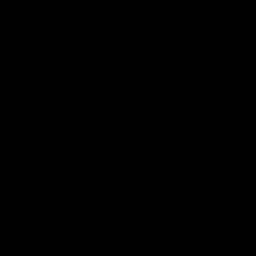

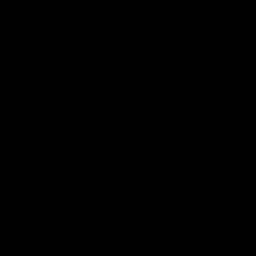

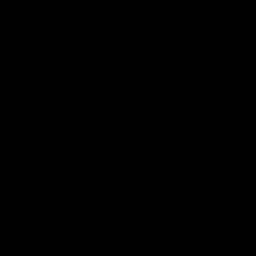

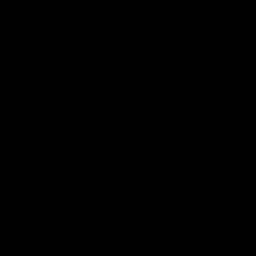

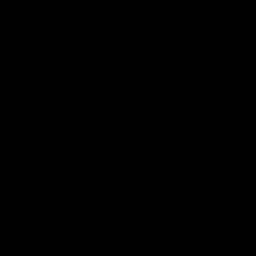

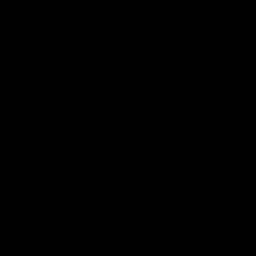

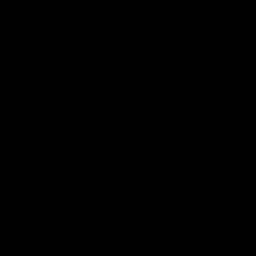

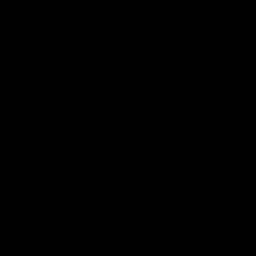

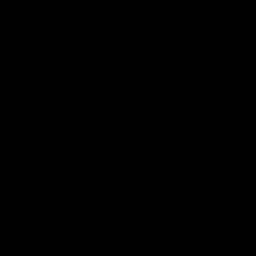

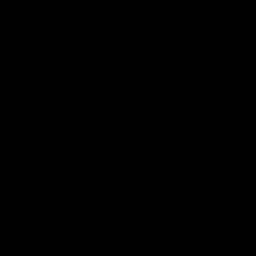

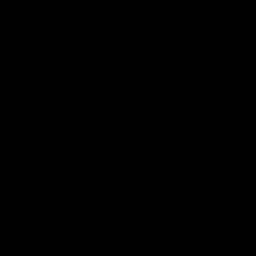

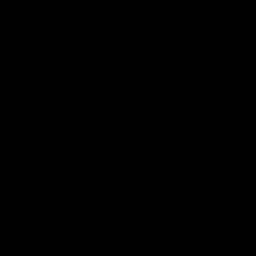

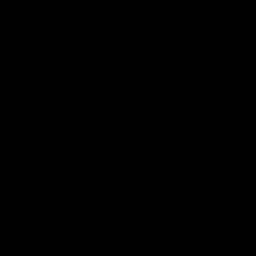

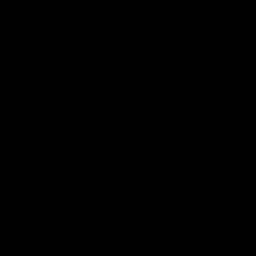

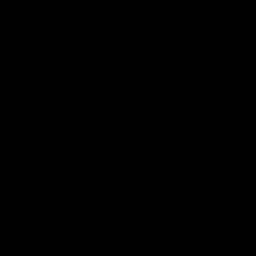

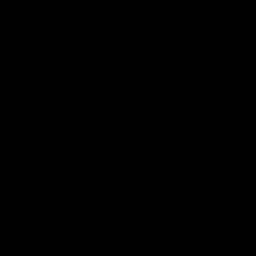

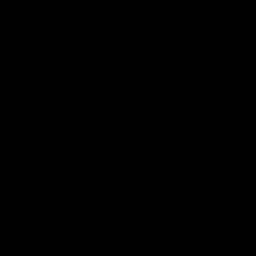

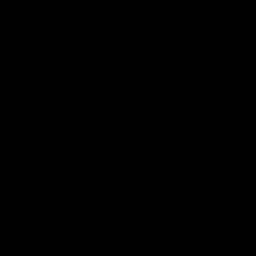

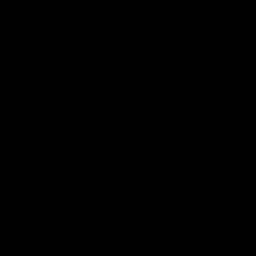

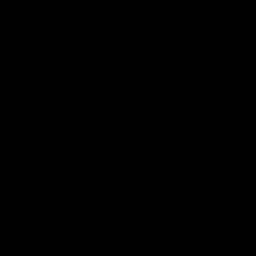

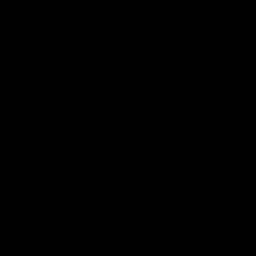

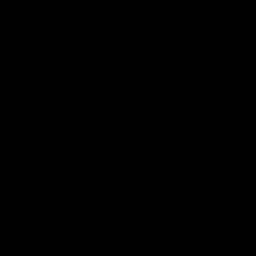

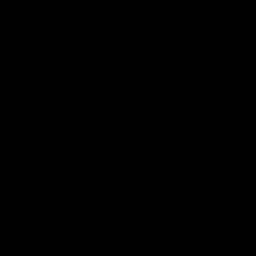

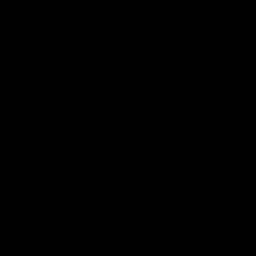

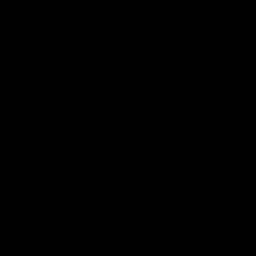

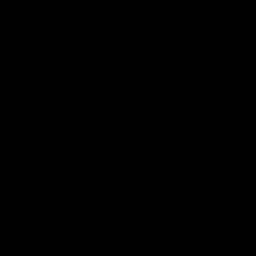

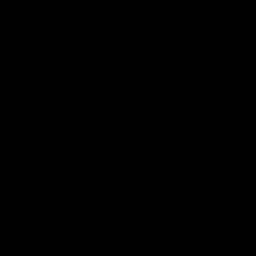

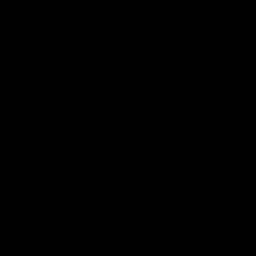

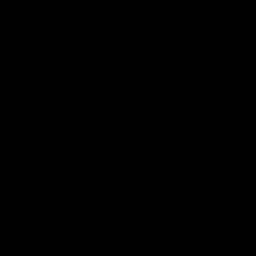

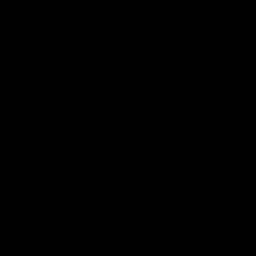

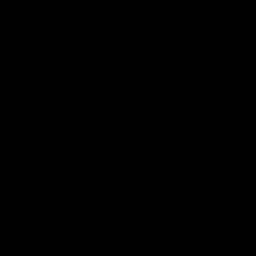

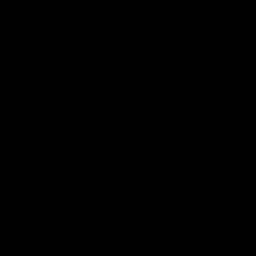

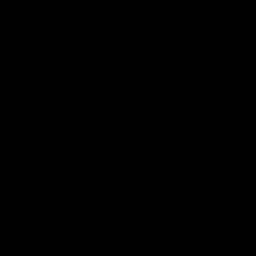

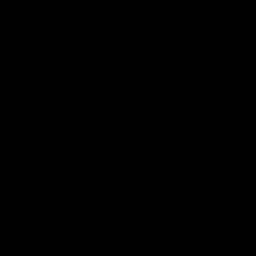

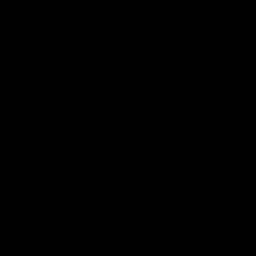

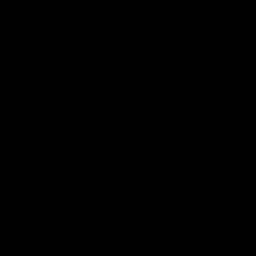

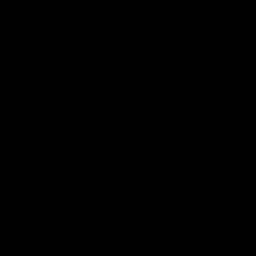

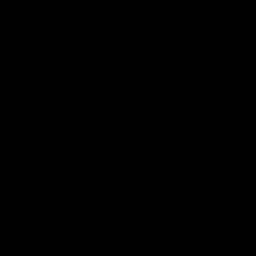

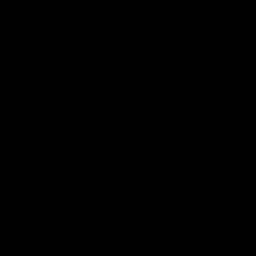

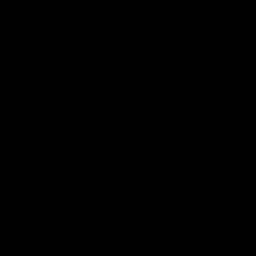

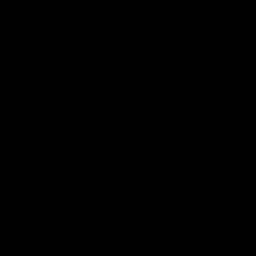

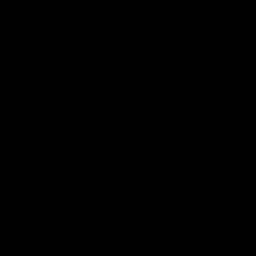

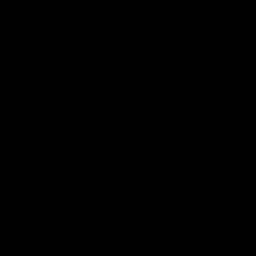

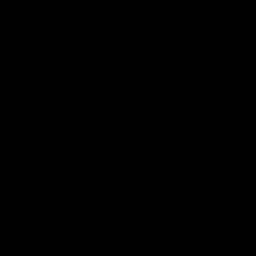

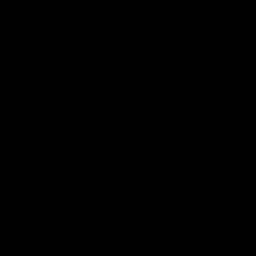

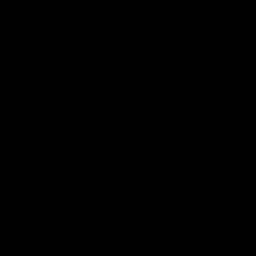

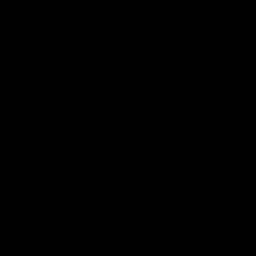

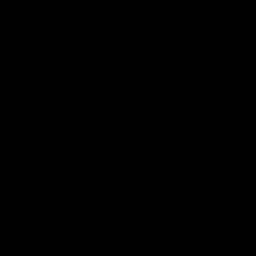

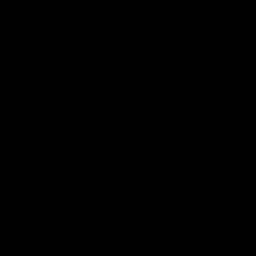

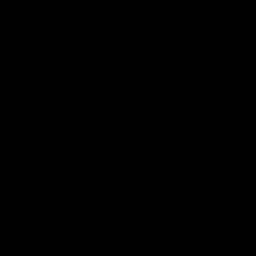

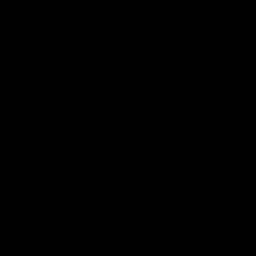

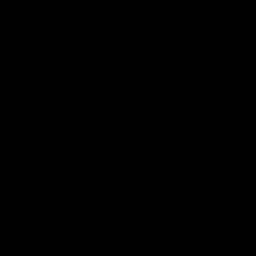

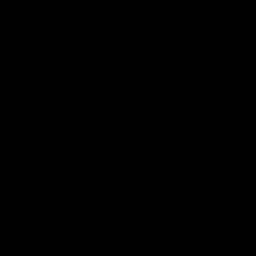

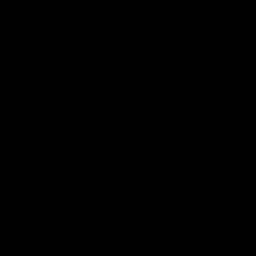

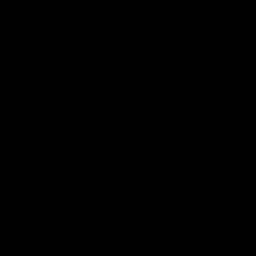

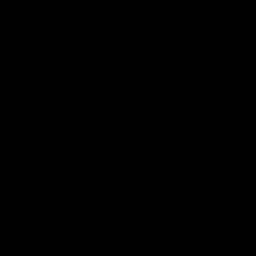

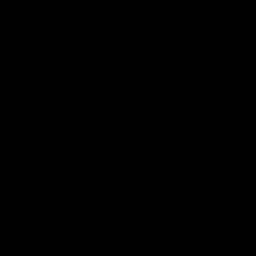

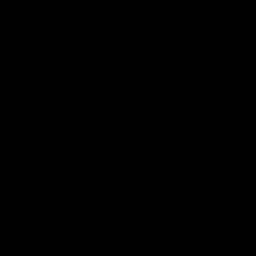

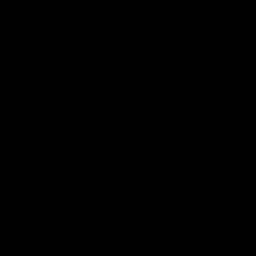

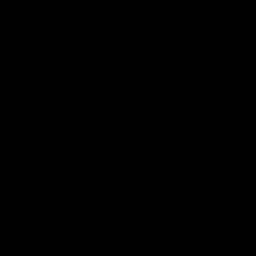

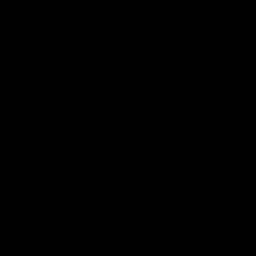

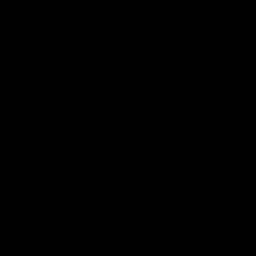

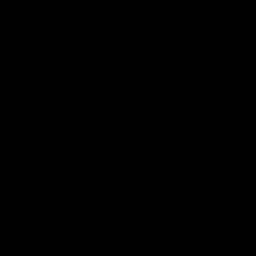

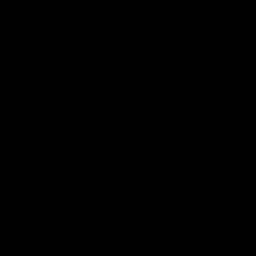

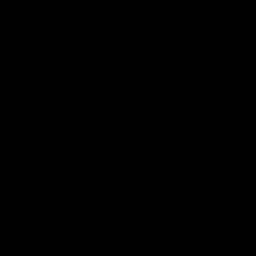

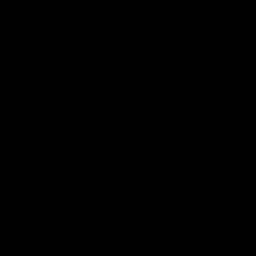

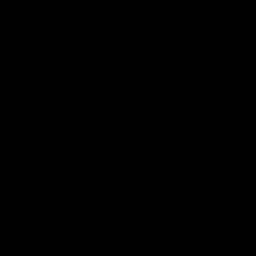

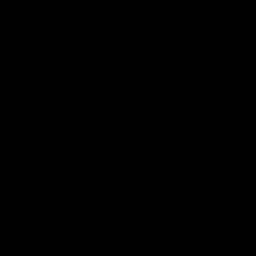

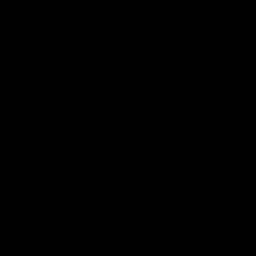

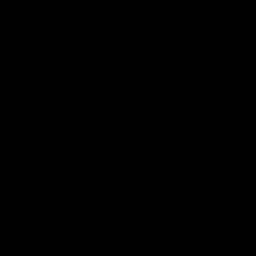

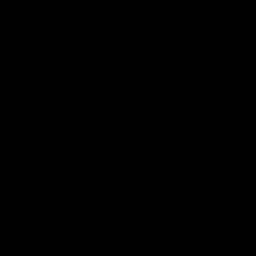

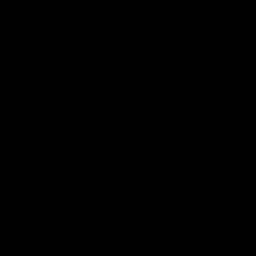

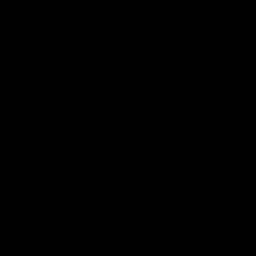

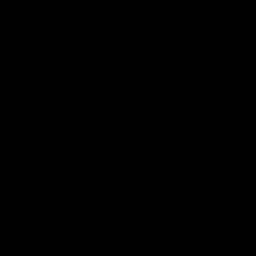

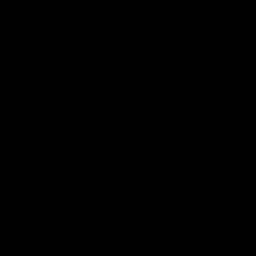

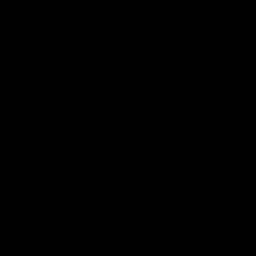

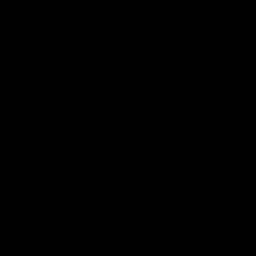

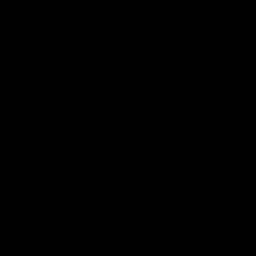

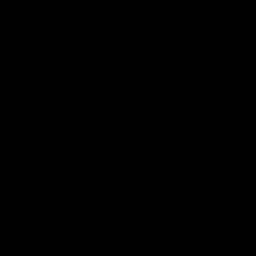

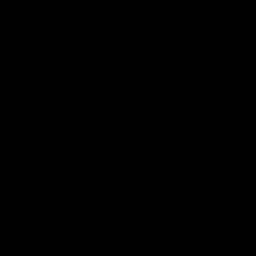

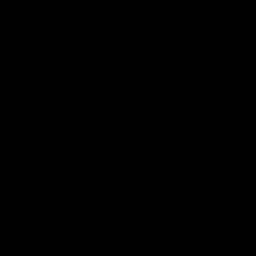

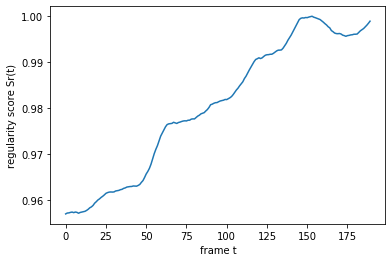

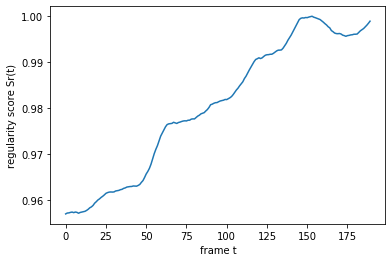

In [15]:

if os.path.isfile(conf.GAN_MODEL_PATH):
    #model=load_model(conf.GAN_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    #discriminator, loaded_dis = get_discriminator()
    model, loaded = get_generator()

else :
    discriminator, loaded_dis = get_discriminator()
    generator, loaded_gen= get_generator()
    model = train(generator, discriminator)

evaluate("Test002", model, 200, 1)